In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [5]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [8]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
fmnist_images = np.concatenate([x_train, x_test], axis = 0)
fmnist_images = np.expand_dims(fmnist_images, -1).astype("float32") / 255
vae = VAE(encoder, decoder)
vae.compile(optimizer ='rmsprop')
vae.fit(fmnist_images, epochs = 100, batch_size = 64)

4422102/4422102 [==============================] - 3s 1us/step
Epoch 1/100
1094/1094 [==============================] - 43s 38ms/step - loss: 337.7729 - reconstruction_loss: 302.1058 - kl_loss: 8.2638
Epoch 2/100
1094/1094 [==============================] - 37s 34ms/step - loss: 286.6977 - reconstruction_loss: 277.2574 - kl_loss: 7.2521
Epoch 3/100
1094/1094 [==============================] - 42s 38ms/step - loss: 279.8989 - reconstruction_loss: 271.1683 - kl_loss: 6.9680
Epoch 4/100
1094/1094 [==============================] - 42s 38ms/step - loss: 274.6236 - reconstruction_loss: 267.6727 - kl_loss: 6.7686
Epoch 5/100
1094/1094 [==============================] - 43s 39ms/step - loss: 272.1834 - reconstruction_loss: 265.1388 - kl_loss: 6.6067
Epoch 6/100
1094/1094 [==============================] - 47s 43ms/step - loss: 270.2966 - reconstruction_loss: 263.3460 - kl_loss: 6.5529
Epoch 7/100
1094/1094 [==============================] - 44s 40ms/step - loss: 268.1408 - reconstruction_loss

1094/1094 [==============================] - 90s 82ms/step - loss: 257.0570 - reconstruction_loss: 250.6256 - kl_loss: 6.7436
Epoch 56/100
1094/1094 [==============================] - 93s 85ms/step - loss: 257.0243 - reconstruction_loss: 250.5510 - kl_loss: 6.7463
Epoch 57/100
1094/1094 [==============================] - 89s 82ms/step - loss: 256.7322 - reconstruction_loss: 250.5328 - kl_loss: 6.7636
Epoch 58/100
1094/1094 [==============================] - 89s 81ms/step - loss: 256.6846 - reconstruction_loss: 250.4299 - kl_loss: 6.7644
Epoch 59/100
1094/1094 [==============================] - 90s 83ms/step - loss: 257.2189 - reconstruction_loss: 250.4180 - kl_loss: 6.7645
Epoch 60/100
1094/1094 [==============================] - 91s 84ms/step - loss: 257.5186 - reconstruction_loss: 250.3702 - kl_loss: 6.7682
Epoch 61/100
1094/1094 [==============================] - 87s 80ms/step - loss: 256.9737 - reconstruction_loss: 250.2887 - kl_loss: 6.7760
Epoch 62/100
1094/1094 [================

1/1 [==============================] - 0s 19ms/step


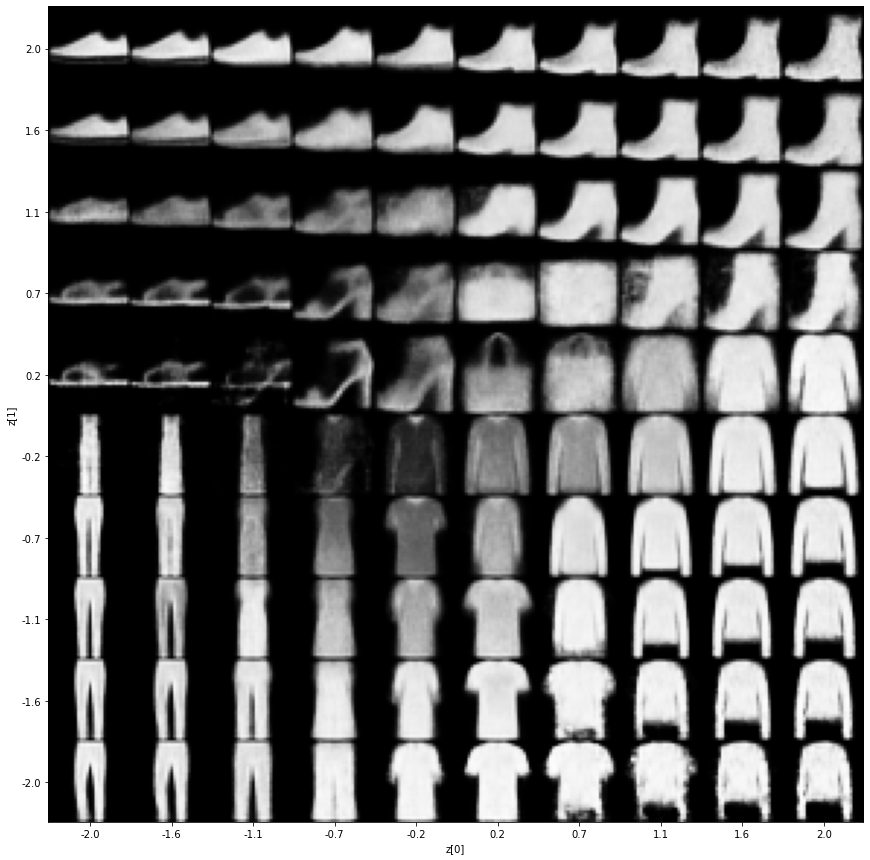

In [16]:
def plot_latent(encoder, decoder):
    # display a n * n 2D manifold of images
    n = 10
    img_dim = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((img_dim * n, img_dim * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of images classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]
    
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            images = x_decoded[0].reshape(img_dim, img_dim)
            figure[
                i * img_dim : (i + 1) * img_dim,
                j * img_dim : (j + 1) * img_dim,
            ] = images

    plt.figure(figsize =(figsize, figsize))
    start_range = img_dim // 2
    end_range = n * img_dim + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_dim)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range[:-1], sample_range_x)
    plt.yticks(pixel_range[:-1], sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap ="Greys_r")
    plt.show()
    
plot_latent(encoder, decoder)

1875/1875 [==============================] - 3s 2ms/step


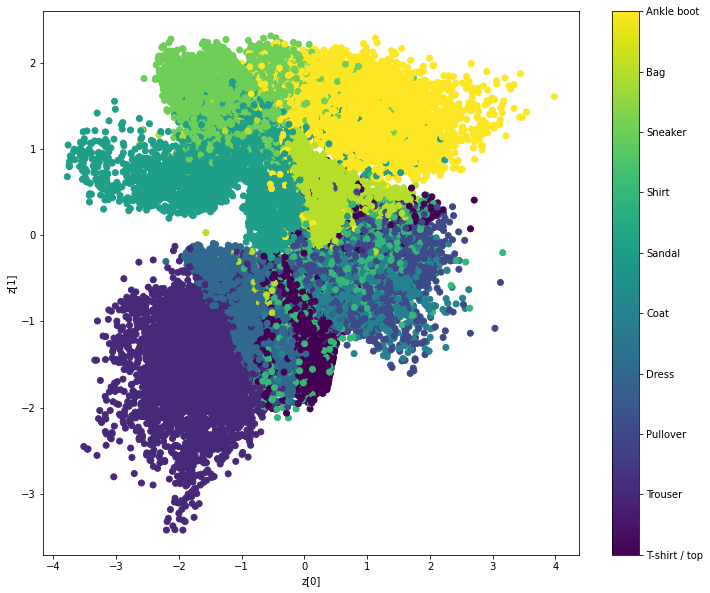

In [10]:
def plot_label_clusters(encoder, decoder, data, test_lab):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize =(12, 10))
    sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
    cbar = plt.colorbar(sc, ticks = range(10))
    cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


labels = {0 :"T-shirt / top",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat",
5: "Sandal",
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Ankle boot"}

(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, decoder, x_train, y_train)